## Testing an Autoencoder

In [270]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
#from keras.layers import containers

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
#encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
#decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
#autoencoder = Model(input=input_img, output=decoded)
# this model maps an input to its reconstruction

# this model maps an input to its reconstruction
#autoencoder = Model(input=input_img, output=decoded)

#2.
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input=input_img, output=decoded)

In [271]:
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_69 (InputLayer)            (None, 784)           0                                            
____________________________________________________________________________________________________
dense_118 (Dense)                (None, 128)           100480      input_69[0][0]                   
____________________________________________________________________________________________________
dense_119 (Dense)                (None, 64)            8256        dense_118[0][0]                  
____________________________________________________________________________________________________
dense_120 (Dense)                (None, 32)            2080        dense_119[0][0]                  
___________________________________________________________________________________________

Separate encoded model 

In [272]:
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)
encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_69 (InputLayer)            (None, 784)           0                                            
____________________________________________________________________________________________________
dense_118 (Dense)                (None, 128)           100480      input_69[0][0]                   
____________________________________________________________________________________________________
dense_119 (Dense)                (None, 64)            8256        dense_118[0][0]                  
____________________________________________________________________________________________________
dense_120 (Dense)                (None, 32)            2080        dense_119[0][0]                  
Total params: 110816
______________________________________________________________________

Decoder Model 

In [273]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
decoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_70 (InputLayer)            (None, 32)            0                                            
____________________________________________________________________________________________________
dense_121 (Dense)                (None, 64)            2112        input_70[0][0]                   
Total params: 2112
____________________________________________________________________________________________________


Compiling model for mninst

In [274]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Preparing data for Trining: Data from MNIST

In [277]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [278]:
y_test.shape

(10000,)

In [279]:

checkpoint_file = 'fc_weights_autoencoder.hdf5'
checkpointer = ModelCheckpoint(filepath=checkpoint_file, verbose=0, save_best_only=True)
history = autoencoder.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),callbacks=[checkpointer])
'''
import os
if os.path.exists('fc_weights_autoencoder.hdf5'):
    autoencoder.load_weights('fc_weights_autoencoder.hdf5')
    autoencoder = model_from_json(open('autoencoder_architecture.json').read())
    autoencoder.load_weights('fc_weights_autoencoder.hdf5')
    
    autoencoder = model_from_json(open('my_model_architecture.json').read())
    autoencoder.load_weights('my_model_weights.h5')
    
else:
    checkpoint_file = 'fc_weights_autoencoder.hdf5'
    checkpointer = ModelCheckpoint(filepath=checkpoint_file, verbose=0, save_best_only=True)
    history = autoencoder.fit(x_train, x_train,
                    nb_epoch=10,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test),callbacks=[checkpointer])
    json_string = autoencoder.to_json()
    open('autoencoder_architecture.json', 'w').write(json_string)
    autoencoder.save_weights('fc_weights_autoencoder.hdf5',overwrite=True)
'''       

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 13s - loss: 0.3686 - val_loss: 0.2644
Epoch 2/50
60000/60000 [==============================] - 12s - loss: 0.2598 - val_loss: 0.2549
Epoch 3/50
60000/60000 [==============================] - 12s - loss: 0.2451 - val_loss: 0.2348
Epoch 4/50
60000/60000 [==============================] - 12s - loss: 0.2238 - val_loss: 0.2131
Epoch 5/50
60000/60000 [==============================] - 11s - loss: 0.2053 - val_loss: 0.1968
Epoch 6/50
60000/60000 [==============================] - 11s - loss: 0.1924 - val_loss: 0.1853
Epoch 7/50
60000/60000 [==============================] - 12s - loss: 0.1833 - val_loss: 0.1781
Epoch 8/50
60000/60000 [==============================] - 12s - loss: 0.1770 - val_loss: 0.1720
Epoch 9/50
60000/60000 [==============================] - 12s - loss: 0.1712 - val_loss: 0.1665
Epoch 10/50
60000/60000 [==============================] - 11s - loss: 0.1663 - val_lo

"\nimport os\nif os.path.exists('fc_weights_autoencoder.hdf5'):\n    autoencoder.load_weights('fc_weights_autoencoder.hdf5')\n    autoencoder = model_from_json(open('autoencoder_architecture.json').read())\n    autoencoder.load_weights('fc_weights_autoencoder.hdf5')\n    \n    autoencoder = model_from_json(open('my_model_architecture.json').read())\n    autoencoder.load_weights('my_model_weights.h5')\n    \nelse:\n    checkpoint_file = 'fc_weights_autoencoder.hdf5'\n    checkpointer = ModelCheckpoint(filepath=checkpoint_file, verbose=0, save_best_only=True)\n    history = autoencoder.fit(x_train, x_train,\n                    nb_epoch=10,\n                    batch_size=256,\n                    shuffle=True,\n                    validation_data=(x_test, x_test),callbacks=[checkpointer])\n    json_string = autoencoder.to_json()\n    open('autoencoder_architecture.json', 'w').write(json_string)\n    autoencoder.save_weights('fc_weights_autoencoder.hdf5',overwrite=True)\n"

In [280]:
encoded_imgs = encoder.predict(x_test)
#decoded_imgs = decoder.predict(encoded_imgs)

In [281]:
encoder.predict(x_test).shape


(10000, 32)

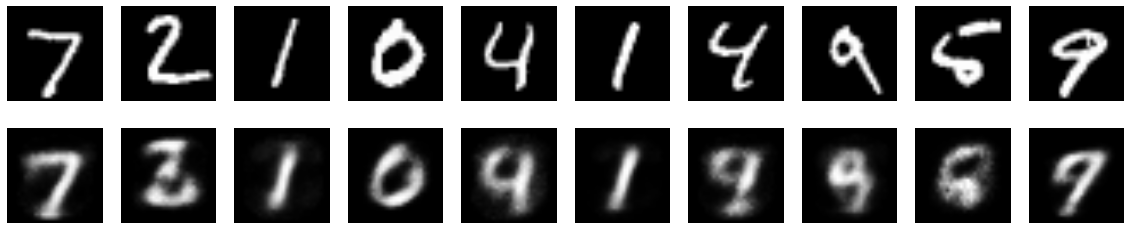

In [282]:
#inline plots

import matplotlib.pyplot as plt
%matplotlib inline
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

K-means with encoded images

In [283]:

from sklearn import cluster
clf = cluster.KMeans(init='k-means++', n_clusters=10)
clf.fit(encoded_imgs)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [284]:
clf.labels_

array([5, 7, 4, ..., 5, 3, 2], dtype=int32)

Try PCA to see how good it might be

In [286]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
#all components
#pca = PCA()

newdataPCA = pca.fit_transform(x_test)  # concatenates vectors row by row

print (pca.explained_variance_ratio_)

[ 0.10047657  0.07544482  0.06140512]


Try TSNE for representing data


In [287]:
from sklearn.manifold import TSNE


print('Calculating TSNE..')
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(x_test)

print('TSNE Done!')

Calculating TSNE..
TSNE Done!


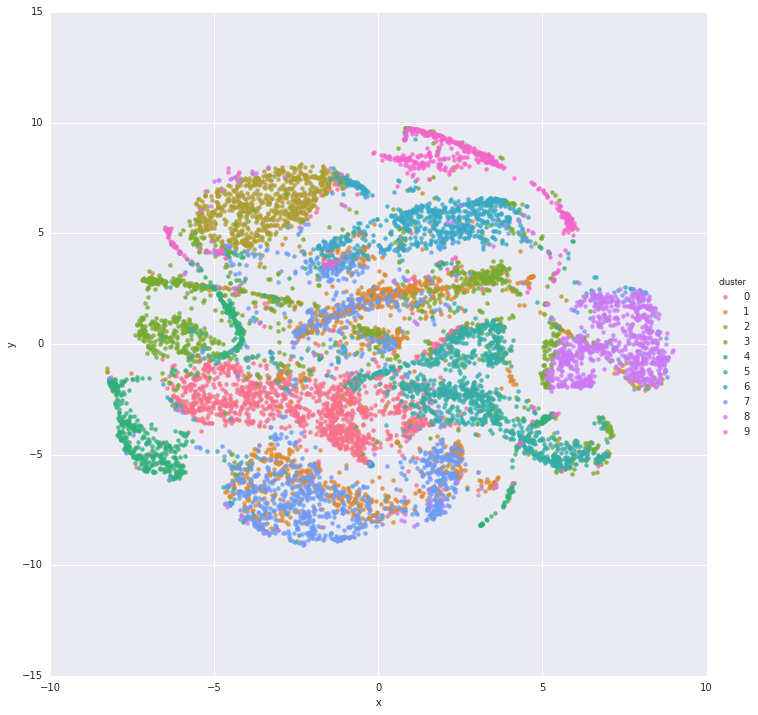

TSNE representation of K-means encoded input


In [288]:

import pandas as pd
import seaborn as sns

data = {"x": [], "y": [], "cluster": []}
for i in range(Y.shape[0]):
    data["x"].append(Y[i][0])
    data["y"].append(Y[i][1])
    data["cluster"].append(clf.labels_[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df,
           fit_reg=False, size=10,
           hue="cluster", legend=True)
plt.show()
print('TSNE representation of K-means encoded input')

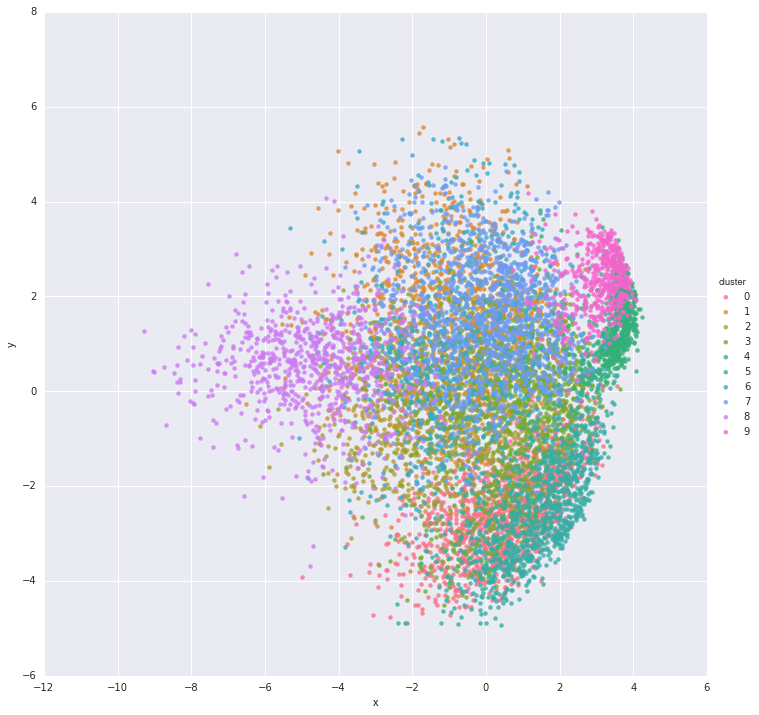

PCA representation of K-means


In [289]:

import pandas as pd
import seaborn as sns

data = {"x": [], "y": [], "cluster": []}
data["x"] = newdataPCA.T[0]
data["y"] = newdataPCA.T[1]
for i in range(Y.shape[0]):
    data["cluster"].append(clf.labels_[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df,
           fit_reg=False, size=10,
           hue="cluster", legend=True)
plt.show()
print('PCA representation of K-means')

## Comparing with learning directly the clusters without encoding 

In [290]:
clf_NO_CODED = cluster.KMeans(init='k-means++', n_clusters=10)
clf_NO_CODED.fit(x_test)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

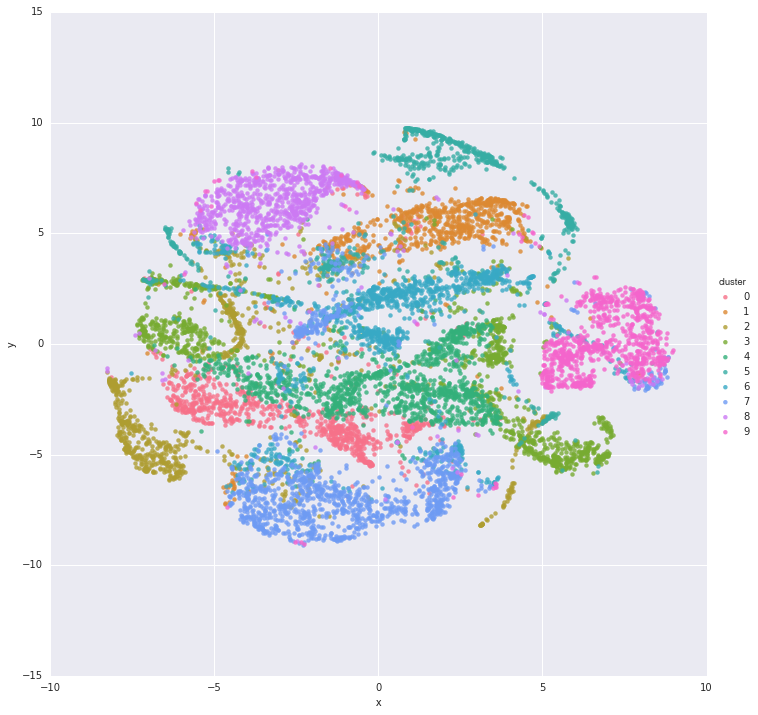

In [291]:
import pandas as pd
import seaborn as sns

data = {"x": [], "y": [], "cluster": []}
for i in range(Y.shape[0]):
    data["x"].append(Y[i][0])
    data["y"].append(Y[i][1])
    data["cluster"].append(clf_NO_CODED.labels_[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df,
           fit_reg=False, size=10,
           hue="cluster", legend=True)
plt.show()

## Drawing with TSNE : input row input

(10000, 2)


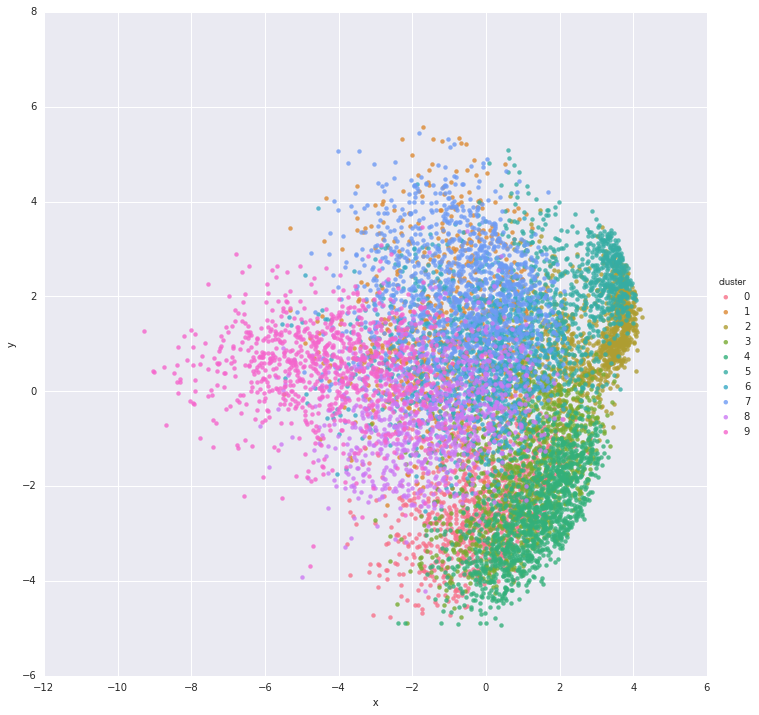

In [292]:

#Visually checking!
print(Y_NO_CODED.shape)
import pandas as pd
import seaborn as sns

data = {"x": [], "y": [], "cluster": []}
data["x"] = (newdataPCA.T[0])
data["y"] = (newdataPCA.T[1])
for i in range(Y.shape[0]):
    data["cluster"].append(clf_NO_CODED.labels_[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df,
           fit_reg=False, size=10,
           hue="cluster", legend=True)
plt.show()

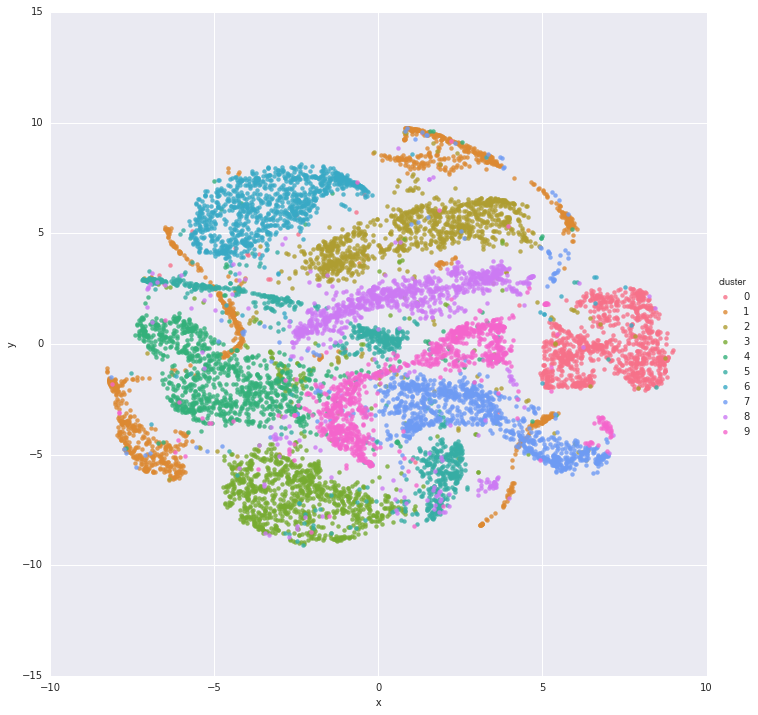

In [293]:
import pandas as pd
import seaborn as sns

data = {"x": [], "y": [], "cluster": []}
for i in range(Y.shape[0]):
    data["x"].append(Y_NO_CODED[i][0])
    data["y"].append(Y_NO_CODED[i][1])
    data["cluster"].append(y_test[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df,
           fit_reg=False, size=10,
           hue="cluster", legend=True)
plt.show()

PCA Row representation

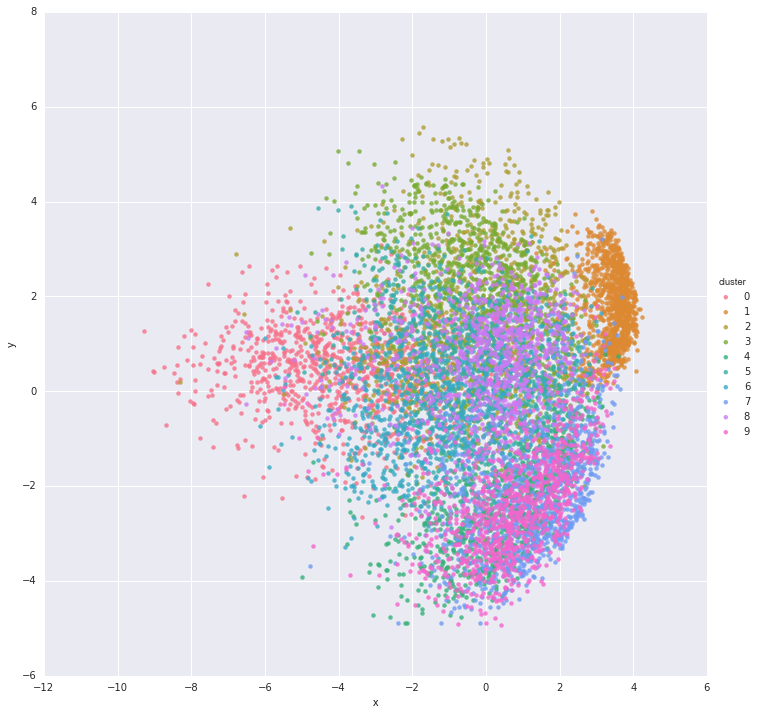

In [294]:
import pandas as pd
import seaborn as sns

data = {"x": [], "y": [], "cluster": []}
data["x"] = (newdataPCA.T[0])
data["y"] = (newdataPCA.T[1])
for i in range(Y.shape[0]):
    data["cluster"].append(y_test[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df,
           fit_reg=False, size=10,
           hue="cluster", legend=True)
plt.show()